In [ ]:


import numpy as np 
import pandas as pd 


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
import librosa


TRAINING_OUTPUT_PATH = "/kaggle/input/final-speech-project/" 

# Path to the original Common Voice audio files
COMMON_VOICE_AUDIO_PATH = "/kaggle/input/common-voice/cv-valid-train/cv-valid-train" # This is where the .mp3s are
COMMON_VOICE_METADATA_CSV = "/kaggle/input/common-voice/cv-valid-train.csv" # Original metadata
if not os.path.exists(TRAINING_OUTPUT_PATH):
    print(f"ERROR: Training output path not found: {TRAINING_OUTPUT_PATH}")
    print("Please ensure you've added the output of your training notebook as a data source.")
    print("You can list contents of /kaggle/input/ to find the correct path:")

if not os.path.exists(COMMON_VOICE_AUDIO_PATH):
    print(f"ERROR: Common Voice audio path not found: {COMMON_VOICE_AUDIO_PATH}")
    print("Please ensure the 'common-voice' dataset is added as a data source.")

print(f"Path for saved models/transformers: {TRAINING_OUTPUT_PATH}")
print(f"Path for test audio files: {COMMON_VOICE_AUDIO_PATH}")

Path for saved models/transformers: /kaggle/input/final-speech-project/
Path for test audio files: /kaggle/input/common-voice/cv-valid-train/cv-valid-train


In [ ]:

loaded_age_model = None
loaded_age_scaler = None
loaded_age_feature_selector = None
loaded_age_label_encoder = None
loaded_gender_model = None
loaded_gender_scaler = None
loaded_gender_feature_selector = None
gender_display_map = {0: "female", 1: "male"}
models_loaded_successfully = False

if os.path.exists(TRAINING_OUTPUT_PATH):
    try:
        # Age Prediction Assets
        loaded_age_model = joblib.load(os.path.join(TRAINING_OUTPUT_PATH, 'age_prediction_model.sav'))
        loaded_age_scaler = joblib.load(os.path.join(TRAINING_OUTPUT_PATH, 'age_scaler.pkl'))
        loaded_age_feature_selector = joblib.load(os.path.join(TRAINING_OUTPUT_PATH, 'age_feature_selector.pkl'))
        loaded_age_label_encoder = joblib.load(os.path.join(TRAINING_OUTPUT_PATH, 'age_label_encoder.pkl'))

        # Gender Prediction Assets
        loaded_gender_model = joblib.load(os.path.join(TRAINING_OUTPUT_PATH, 'gender_prediction_model.sav'))
        loaded_gender_scaler = joblib.load(os.path.join(TRAINING_OUTPUT_PATH, 'gender_scaler.pkl'))
        loaded_gender_feature_selector = joblib.load(os.path.join(TRAINING_OUTPUT_PATH, 'gender_feature_selector.pkl'))

        print("All models and transformers loaded successfully.")
        models_loaded_successfully = True

    except FileNotFoundError as e:
        print(f"ERROR: Could not load one or more saved model/transformer files: {e}")
        print(f"Please check that all .sav and .pkl files exist in {TRAINING_OUTPUT_PATH}")
        print("Files found in training output path:", os.listdir(TRAINING_OUTPUT_PATH) if os.path.exists(TRAINING_OUTPUT_PATH) else "Path does not exist")
    except Exception as e:
        print(f"An unexpected error occurred during loading: {e}")
else:
    print(f"Skipping model loading as TRAINING_OUTPUT_PATH ({TRAINING_OUTPUT_PATH}) does not exist.")


df_original_metadata = None
if os.path.exists(COMMON_VOICE_METADATA_CSV):
    try:
        df_original_metadata = pd.read_csv(COMMON_VOICE_METADATA_CSV)
        print(f"Original metadata loaded with shape: {df_original_metadata.shape}")
    except Exception as e:
        print(f"Error loading original metadata CSV: {e}")
else:
    print(f"Warning: Original metadata CSV not found at {COMMON_VOICE_METADATA_CSV}.")

All models and transformers loaded successfully.
Original metadata loaded with shape: (195776, 8)


In [13]:
# This function extracts only the audio features (spectral + MFCCs)
# It must produce a 2D array with 1 row and 23 columns (3 spectral + 20 MFCCs)
def extract_raw_audio_features_for_prediction(filepath, sampling_rate=48000):
    audio_only_feats = []
    try:
        if not os.path.exists(filepath):
            print(f"Prediction Error: Audio file not found at {filepath}")
            return None
        audio, _ = librosa.load(filepath, sr=sampling_rate)

        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sampling_rate))
        spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sampling_rate))
        spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sampling_rate))
        audio_only_feats.extend([spectral_centroid, spectral_bandwidth, spectral_rolloff])

        mfcc = librosa.feature.mfcc(y=audio, sr=sampling_rate, n_mfcc=20) # Ensure n_mfcc=20
        for el in mfcc:
            audio_only_feats.append(np.mean(el))

        return np.array(audio_only_feats).reshape(1, -1) # Reshape for scaler
    except Exception as e:
        print(f"Error extracting features from {filepath}: {e}")
        return None

In [14]:
def predict_speaker_attributes(audio_filepath):
    if not models_loaded_successfully: # Check the flag set in Cell 2
        print("Models/transformers not loaded. Cannot predict.")
        return {"age": "Error - Model/Transformer Not Loaded", "gender": "Error - Model/Transformer Not Loaded"}

    print(f"\nPredicting for: {os.path.basename(audio_filepath)}")
    try:
        # 1. Extract raw audio features (23 features: 3 spectral + 20 MFCCs)
        raw_features_for_pred = extract_raw_audio_features_for_prediction(audio_filepath)
        if raw_features_for_pred is None:
             return {"age": "Error - Feature Extraction Failed", "gender": "Error - Feature Extraction Failed"}

        # 2. Predict Gender first
        scaled_features_for_gender_pred = loaded_gender_scaler.transform(raw_features_for_pred)
        selected_features_for_gender_pred = loaded_gender_feature_selector.transform(scaled_features_for_gender_pred)
        predicted_gender_encoded = loaded_gender_model.predict(selected_features_for_gender_pred)
        predicted_gender_numeric = int(predicted_gender_encoded[0])
        predicted_gender_label = gender_display_map.get(predicted_gender_numeric, "unknown_predicted_gender")

        # 3. Prepare features for Age prediction
        features_for_age_input = np.insert(raw_features_for_pred, 0, predicted_gender_numeric).reshape(1, -1)

        scaled_features_for_age_pred = loaded_age_scaler.transform(features_for_age_input)
        selected_features_for_age_pred = loaded_age_feature_selector.transform(scaled_features_for_age_pred)
        predicted_age_encoded = loaded_age_model.predict(selected_features_for_age_pred)
        predicted_age_label = loaded_age_label_encoder.inverse_transform(predicted_age_encoded)[0]

        print(f"---> Predicted Age: {predicted_age_label}")
        print(f"---> Predicted Gender: {predicted_gender_label}")

        return {"age": predicted_age_label, "gender": predicted_gender_label}

    except Exception as e:
        print(f"Error during prediction for {audio_filepath}: {e}")
        import traceback
        traceback.print_exc()
        return {"age": "Error - Prediction Failed", "gender": "Error - Prediction Failed"}

In [ ]:
if models_loaded_successfully: 
    test_audio_relative_filenames = [
        "sample-000005.mp3",
        "sample-000008.mp3",
        "sample-000013.mp3",
        "sample-000019.mp3", 
        "sample-000002.mp3" 
    ]

    for fname_short in test_audio_relative_filenames:
        
        full_audio_path = os.path.join(COMMON_VOICE_AUDIO_PATH, fname_short)

        if not os.path.exists(full_audio_path):
            print(f"Warning: Test audio file not found: {full_audio_path}. Skipping.")
            continue

        
        if df_original_metadata is not None:
          
            base_folder_for_csv = os.path.basename(os.path.normpath(COMMON_VOICE_AUDIO_PATH))
            filename_in_csv_format = os.path.join(base_folder_for_csv, fname_short)

            actual_info = df_original_metadata[df_original_metadata['filename'] == filename_in_csv_format]
            if not actual_info.empty:
                actual_age = actual_info['age'].iloc[0]
                actual_gender_csv = actual_info['gender'].iloc[0] # This is 'male', 'female'
                print(f"\nActual from CSV for {filename_in_csv_format} -> Age: {actual_age}, Gender: {actual_gender_csv}")
            else:
                print(f"\nNo actual metadata found in CSV for {filename_in_csv_format}")
        else:
            print(f"\nOriginal metadata not loaded. Cannot show actuals for {fname_short}.")

        predict_speaker_attributes(full_audio_path)
        print("-" * 40)

else:
    print("Models were not loaded successfully. Skipping test predictions.")




Actual from CSV for cv-valid-train/sample-000005.mp3 -> Age: twenties, Gender: female

Predicting for: sample-000005.mp3
---> Predicted Age: twenties
---> Predicted Gender: female
----------------------------------------

Actual from CSV for cv-valid-train/sample-000008.mp3 -> Age: seventies, Gender: male

Predicting for: sample-000008.mp3
---> Predicted Age: seventies
---> Predicted Gender: male
----------------------------------------

Actual from CSV for cv-valid-train/sample-000013.mp3 -> Age: thirties, Gender: female

Predicting for: sample-000013.mp3
---> Predicted Age: thirties
---> Predicted Gender: female
----------------------------------------

Actual from CSV for cv-valid-train/sample-000019.mp3 -> Age: fifties, Gender: male

Predicting for: sample-000019.mp3
---> Predicted Age: twenties
---> Predicted Gender: male
----------------------------------------

Actual from CSV for cv-valid-train/sample-000002.mp3 -> Age: nan, Gender: nan

Predicting for: sample-000002.mp3
---> 

In [ ]:
import os
import joblib
import numpy as np
import pandas as pd
import librosa

TRAINING_OUTPUT_PATH = "/kaggle/input/final-speech-project/" 


TEST_SET_METADATA_CSV = "/kaggle/input/common-voice/cv-valid-test.csv"  
TEST_SET_AUDIO_PATH = "/kaggle/input/common-voice/cv-valid-test/cv-valid-test"    

if not os.path.exists(TRAINING_OUTPUT_PATH):
    print(f"ERROR: Training output path not found: {TRAINING_OUTPUT_PATH}")

if not os.path.exists(TEST_SET_METADATA_CSV):
    print(f"ERROR: Test set metadata CSV not found: {TEST_SET_METADATA_CSV}")
if not os.path.exists(TEST_SET_AUDIO_PATH):
    print(f"ERROR: Test set audio path not found: {TEST_SET_AUDIO_PATH}")


print(f"Path for saved models/transformers: {TRAINING_OUTPUT_PATH}")
print(f"Path for TEST audio files: {TEST_SET_AUDIO_PATH}")
print(f"Path for TEST metadata CSV: {TEST_SET_METADATA_CSV}")

Path for saved models/transformers: /kaggle/input/final-speech-project/
Path for TEST audio files: /kaggle/input/common-voice/cv-valid-test/cv-valid-test
Path for TEST metadata CSV: /kaggle/input/common-voice/cv-valid-test.csv


In [ ]:

loaded_age_model = None
loaded_age_scaler = None
loaded_age_feature_selector = None
loaded_age_label_encoder = None
loaded_gender_model = None
loaded_gender_scaler = None
loaded_gender_feature_selector = None
gender_display_map = {0: "female", 1: "male"}
models_loaded_successfully = False

if os.path.exists(TRAINING_OUTPUT_PATH):
    try:
        # Age Prediction Assets
        loaded_age_model = joblib.load(os.path.join(TRAINING_OUTPUT_PATH, 'age_prediction_model.sav'))
        loaded_age_scaler = joblib.load(os.path.join(TRAINING_OUTPUT_PATH, 'age_scaler.pkl'))
        loaded_age_feature_selector = joblib.load(os.path.join(TRAINING_OUTPUT_PATH, 'age_feature_selector.pkl'))
        loaded_age_label_encoder = joblib.load(os.path.join(TRAINING_OUTPUT_PATH, 'age_label_encoder.pkl'))

        # Gender Prediction Assets
        loaded_gender_model = joblib.load(os.path.join(TRAINING_OUTPUT_PATH, 'gender_prediction_model.sav'))
        loaded_gender_scaler = joblib.load(os.path.join(TRAINING_OUTPUT_PATH, 'gender_scaler.pkl'))
        loaded_gender_feature_selector = joblib.load(os.path.join(TRAINING_OUTPUT_PATH, 'gender_feature_selector.pkl'))

        print("All models and transformers loaded successfully.")
        models_loaded_successfully = True

    except FileNotFoundError as e:
        print(f"ERROR: Could not load one or more saved model/transformer files: {e}")
        print(f"Please check that all .sav and .pkl files exist in {TRAINING_OUTPUT_PATH}")
    except Exception as e:
        print(f"An unexpected error occurred during loading: {e}")
else:
    print(f"Skipping model loading as TRAINING_OUTPUT_PATH ({TRAINING_OUTPUT_PATH}) does not exist.")


df_test_metadata = None
if os.path.exists(TEST_SET_METADATA_CSV):
    try:
        df_test_metadata = pd.read_csv(TEST_SET_METADATA_CSV)
    
        df_test_metadata = df_test_metadata[df_test_metadata['age'].notna() & df_test_metadata['gender'].notna()]
        

        print(f"Test set metadata loaded and cleaned with shape: {df_test_metadata.shape}")
        if df_test_metadata.empty:
            print("Warning: Test metadata is empty after cleaning NaNs for age/gender.")
    except Exception as e:
        print(f"Error loading or cleaning test metadata CSV: {e}")
else:
    print(f"Warning: Test set metadata CSV not found at {TEST_SET_METADATA_CSV}.")

All models and transformers loaded successfully.
Test set metadata loaded and cleaned with shape: (1535, 8)


In [ ]:
import itertools

def my_plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.nan_to_num(cm) 
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    fmt = ".2f" if normalize else "d"
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


--- Starting testing on the ENTIRE test set from /kaggle/input/common-voice/cv-valid-test.csv ---
Total test samples to process: 1535

Predicting for: sample-000001.mp3
---> Predicted Age: teens
---> Predicted Gender: male

Predicting for: sample-000003.mp3
---> Predicted Age: twenties
---> Predicted Gender: male

Predicting for: sample-000005.mp3
---> Predicted Age: twenties
---> Predicted Gender: male

Predicting for: sample-000006.mp3
---> Predicted Age: fourties
---> Predicted Gender: male

Predicting for: sample-000007.mp3
---> Predicted Age: fifties
---> Predicted Gender: male

Predicting for: sample-000008.mp3
---> Predicted Age: twenties
---> Predicted Gender: male

Predicting for: sample-000009.mp3
---> Predicted Age: fifties
---> Predicted Gender: male

Predicting for: sample-000011.mp3
---> Predicted Age: twenties
---> Predicted Gender: male

Predicting for: sample-000014.mp3
---> Predicted Age: twenties
---> Predicted Gender: male

Predicting for: sample-000016.mp3
---> Pr

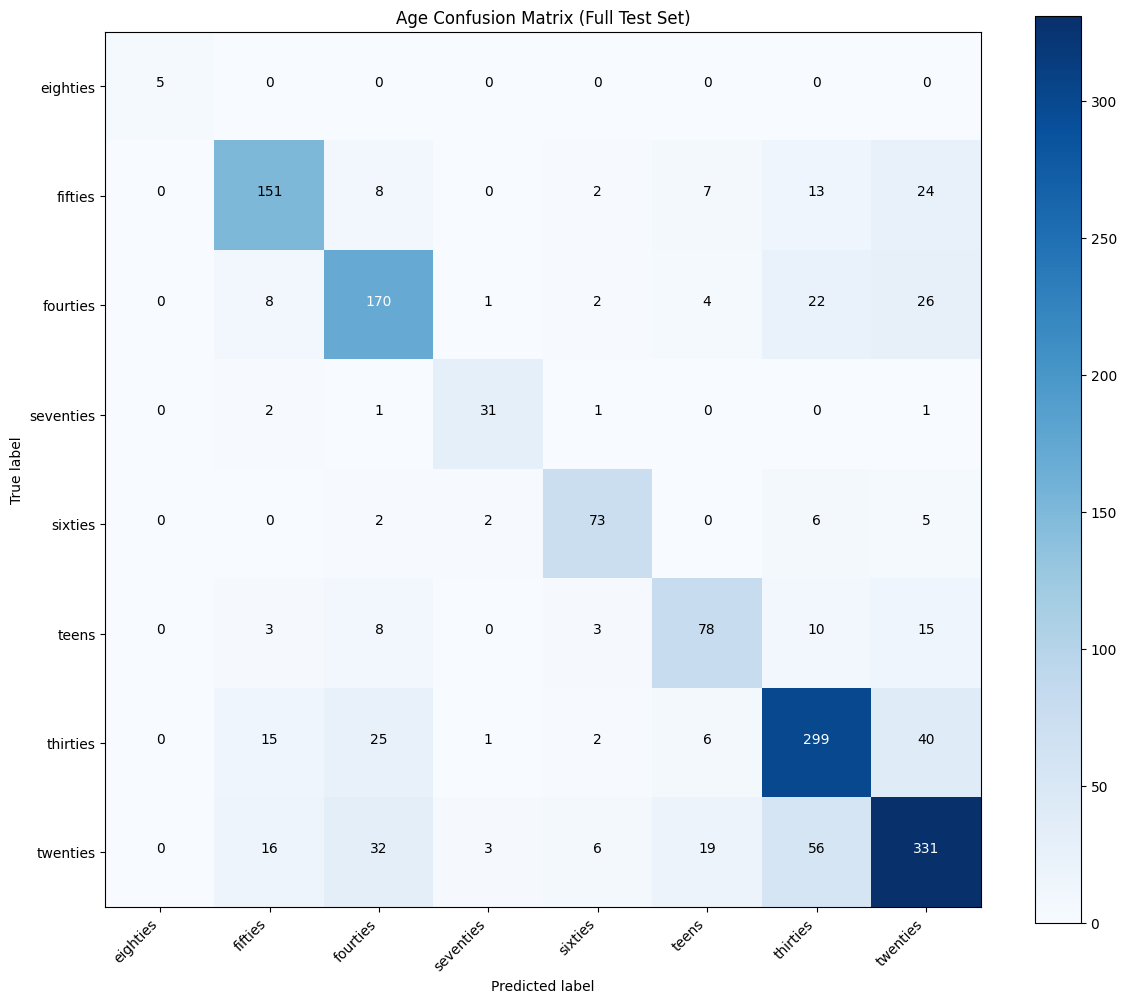

Normalized confusion matrix


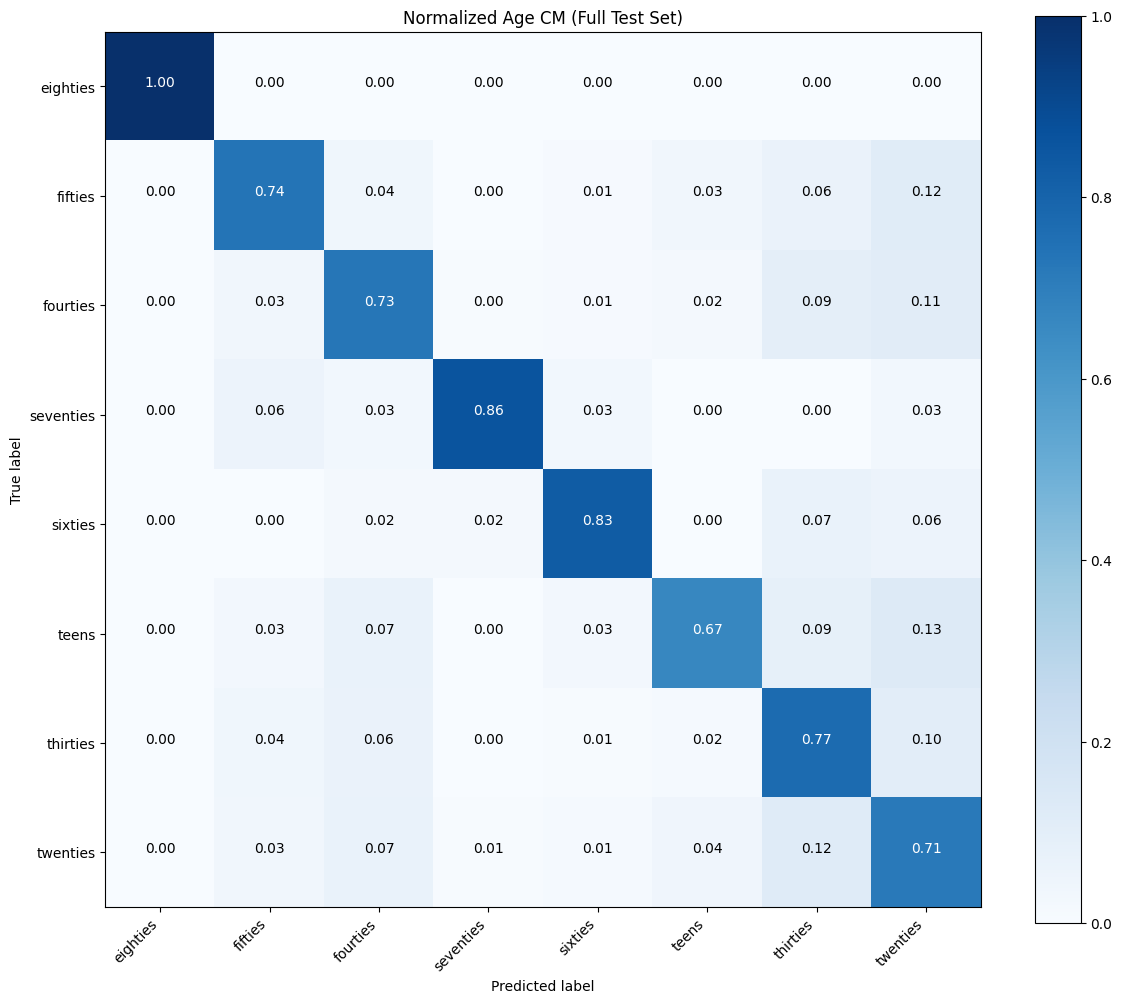



--- GENDER PREDICTION PERFORMANCE (Full Test Set) ---
Overall Gender Accuracy (on 'male'/'female' actuals): 0.9120

Gender Classification Report (on 'male'/'female' actuals):
              precision    recall  f1-score   support

      female       0.85      0.79      0.82       390
        male       0.93      0.95      0.94      1133

    accuracy                           0.91      1523
   macro avg       0.89      0.87      0.88      1523
weighted avg       0.91      0.91      0.91      1523

Confusion matrix, without normalization


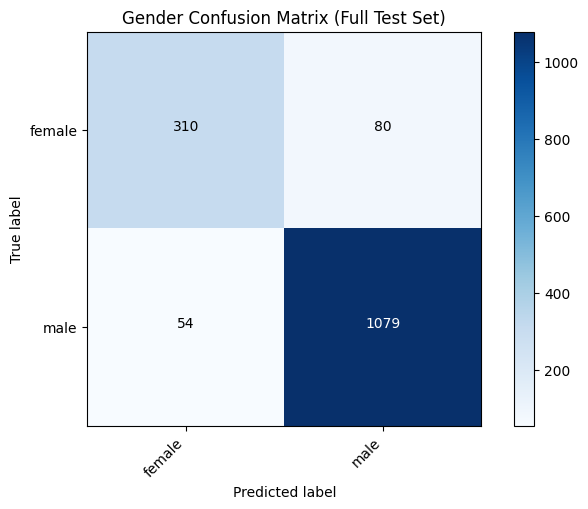

Normalized confusion matrix


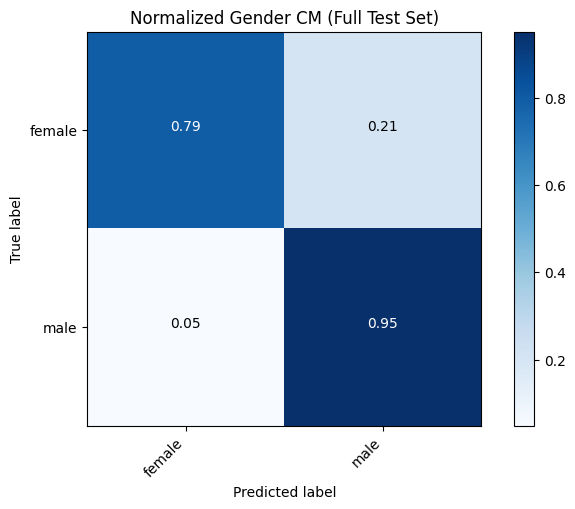

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt 

if models_loaded_successfully and df_test_metadata is not None and not df_test_metadata.empty:
    print(f"\n--- Starting testing on the ENTIRE test set from {TEST_SET_METADATA_CSV} ---")
    print(f"Total test samples to process: {len(df_test_metadata)}")

    all_actual_ages = []
    all_predicted_ages = []
    all_actual_genders_str_from_csv = [] 
    all_predicted_genders_str_from_model = [] 

    processed_count = 0
    error_count = 0

    for index, row in df_test_metadata.iterrows():
        processed_count += 1
        if processed_count % 100 == 0 or processed_count == len(df_test_metadata): 
            print(f"\rProcessing test sample {processed_count}/{len(df_test_metadata)} (Errors: {error_count})", end="", flush=True)

        filename_from_csv = row['filename']
        actual_age = row['age']
        actual_gender_csv_val = row['gender'] 

    
        if filename_from_csv.startswith(os.path.basename(os.path.normpath(TEST_SET_AUDIO_PATH))):
             actual_filename_to_join = os.path.basename(filename_from_csv)
             full_audio_path = os.path.join(TEST_SET_AUDIO_PATH, actual_filename_to_join)
        else:
             full_audio_path = os.path.join(TEST_SET_AUDIO_PATH, filename_from_csv)

        if not os.path.exists(full_audio_path):
            error_count +=1
            continue

        predictions = predict_speaker_attributes(full_audio_path) 

        if predictions['age'] != "Error - Model/Transformer Not Loaded" and not predictions['age'].startswith("Error"):
            all_actual_ages.append(actual_age)
            all_predicted_ages.append(predictions['age'])
        else:
            error_count +=1

        if predictions['gender'] != "Error - Model/Transformer Not Loaded" and not predictions['gender'].startswith("Error"):
            all_actual_genders_str_from_csv.append(actual_gender_csv_val)
            all_predicted_genders_str_from_model.append(predictions['gender'])
        else:
            pass 

    print(f"\n\nFinished processing test set. Total Processed: {processed_count}, Errors/Skipped: {error_count}")

    # AGE PREDICTION METRICS
    if all_actual_ages and all_predicted_ages:
        print("\n\n--- AGE PREDICTION PERFORMANCE (Full Test Set) ---")
        age_accuracy = accuracy_score(all_actual_ages, all_predicted_ages)
        print(f"Overall Age Accuracy: {age_accuracy:.4f}")

        age_cls_report = classification_report(all_actual_ages, all_predicted_ages, labels=loaded_age_label_encoder.classes_, zero_division=0)
        print("\nAge Classification Report:")
        print(age_cls_report)

        cm_age_test_full = confusion_matrix(all_actual_ages, all_predicted_ages, labels=loaded_age_label_encoder.classes_)
        plt.figure(figsize=(12, 10))
        my_plot_confusion_matrix(cm_age_test_full, classes=loaded_age_label_encoder.classes_, title='Age Confusion Matrix (Full Test Set)')
        plt.grid(False); plt.show()

        plt.figure(figsize=(12, 10))
        my_plot_confusion_matrix(cm_age_test_full, classes=loaded_age_label_encoder.classes_, normalize=True, title='Normalized Age CM (Full Test Set)')
        plt.grid(False); plt.show()

    else:
        print("Not enough valid age predictions to calculate metrics.")

    # GENDER PREDICTION METRICS
    if all_actual_genders_str_from_csv and all_predicted_genders_str_from_model:
        print("\n\n--- GENDER PREDICTION PERFORMANCE (Full Test Set) ---")
        filtered_actual_genders_for_eval = []
        corresponding_predicted_genders_for_eval = []

        for actual_g, predicted_g in zip(all_actual_genders_str_from_csv, all_predicted_genders_str_from_model):
            if actual_g in ['male', 'female']:
                filtered_actual_genders_for_eval.append(actual_g)
                corresponding_predicted_genders_for_eval.append(predicted_g)
        
        if filtered_actual_genders_for_eval:
            gender_accuracy = accuracy_score(filtered_actual_genders_for_eval, corresponding_predicted_genders_for_eval)
            print(f"Overall Gender Accuracy (on 'male'/'female' actuals): {gender_accuracy:.4f}")

            gender_cls_report = classification_report(filtered_actual_genders_for_eval, corresponding_predicted_genders_for_eval, labels=['female', 'male'], zero_division=0)
            print("\nGender Classification Report (on 'male'/'female' actuals):")
            print(gender_cls_report)

            cm_gender_test_full = confusion_matrix(filtered_actual_genders_for_eval, corresponding_predicted_genders_for_eval, labels=['female', 'male'])
            plt.figure(figsize=(7, 5))
            my_plot_confusion_matrix(cm_gender_test_full, classes=['female', 'male'], title='Gender Confusion Matrix (Full Test Set)')
            plt.grid(False); plt.show()

            plt.figure(figsize=(7, 5))
            my_plot_confusion_matrix(cm_gender_test_full, classes=['female', 'male'], normalize=True, title='Normalized Gender CM (Full Test Set)')
            plt.grid(False); plt.show()
        else:
            print("No 'male' or 'female' actual genders in the test set to evaluate against model predictions.")
    else:
        print("Not enough valid gender predictions to calculate metrics.")

else:
    if not models_loaded_successfully:
        print("Models were not loaded. Cannot run test evaluations.")
    if df_test_metadata is None or df_test_metadata.empty:
        print("Test metadata not loaded or is empty. Cannot run test evaluations.")
